In [13]:
#Set these parameters to desired values before running the code

region_file = "observed_target_info.reg" #The region file with supernova coordinates and redshifts

fits_directory='./' #The directory to look for .fits files in   

output_file="output " #The output file name without an extension. Include a space at the end.

uv_type = 'FUV' #Specify FUV or NUV observations


In [14]:
#General use
import numpy as np
from astropy.io import fits
from astropy.cosmology import WMAP9 as cosmo

#For creating a list of .fits files to perform photometry on
import os

#For reading and creating tables
from astropy.table import Table
import astropy.io.ascii as asc

#For performing photometry
from astropy import units as u
from photutils import aperture_photometry, SkyCircularAperture, CircularAperture
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

#For generating a plot
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline


In [15]:
#We define functions used to calculate the error in different values

'''
    Find error in the conversion factor from arcmin^2 to Kpc^2 using a black box error method.

    Args:
        val (float): A redshift value
        err (float): Error in the redshift
        
    Returns:
        error (float): Error in the conversion factor
'''

def Conv_error(val,err): 
    
    error = abs(((1/cosmo.kpc_comoving_per_arcmin(val+err))**2-(1/cosmo.kpc_comoving_per_arcmin(val-err))**2)/2).value
    return(error)


'''
    Find error in the comoving distance using a black box error method

    Args:
        val (float): A redshift value
        err (float): Error in the redshift
        
    Returns:
        error (float): Error in comoving distance 
'''

def Comov_error(val,err):
    
    error = abs(((cosmo.comoving_distance(val+err).cgs)-(cosmo.comoving_distance(val-err).cgs))/2).value           
    return(error)


'''
    Find error in the calculated flux due to error in the measured photon counts per second
    
    Args:
        val (float): Average photon counts per second
        err (float): Error in val
        
    Returns:
        error (float): Error in the flux
'''

def Flux_error(val,err):

    error = ((val*flux_conv_err)**2+(flux_conv*err)**2)**(1/2)
    return(error)


'''
    Find error in the calculated Luminosity due error in the flux and comoving distance
    
    Args:
        flux     (float): Average photon counts per second
        flux_err (float): Error in val
        dist     (float): Comoving distance
        dist_err (float): Error in comoving distance
        
    Returns:
        error (float): Error in the luminosity
'''

def Luminosity_error(flux,flux_err,dist,dist_err): #The input 'dist' is Comoving Distance

    error = ((4*np.pi*(dist**2)*flux_err)**2+(8*np.pi*dist*flux*dist_err)**2)**(1/2)
    return(error)


'''
    Find the error in surface brightness 
    
    Args:
        lum      (float): Luminosity of a supernova environment
        lum_err  (float): Error in the luminosity
        conv     (float): Conversion factor from arcmin^2 to Kpc^2 
        conv_err (float): Error in the conversion factor
        
    Returns:
        error (float): Error in the Surface brightness
'''

def Sbrightness_error(lum,lum_err,conv,conv_err): #Uncertanty in surface brightness
    
    error = ((conv*lum_err/pixel_area)**2+(lum*conv_err/pixel_area)**2+
         (lum*conv*pixel_area_err/(pixel_area**2))**2)**(1/2)
    
    return(error)


In [16]:
'''
    Perform photometry on a .fits file using a 1kpc radius aperture. 
    
    Args:
        fits_file (str): The file path of a .fits file

    Returns:
        results (list): [supernova name (string), photometry value (float), exposure time (float)]
        'none'  (str) : Returned if photometry of a supernova is zero and there was no check file
        False   (bool): Returned if no supernova is found in the .fits file
'''

def photometry(fits_file):

    #open the file and create an hdulist
    hdulist = fits.open(fits_file)
    sci = hdulist[0].data
    wcs = WCS(fits_file)

    for sn in cord:

        #Define the SN location in pixels
        w = wcs.all_world2pix(cord[sn].ra,cord[sn].dec, 1)
        
        #Make sure the sn is located in the image
        if 0<w[0]<3600 and 0<w[1]<3600:

            #get exposure time and create an array of the error in each pixel
            exp_time = hdulist[0].header['EXPTIME']
            error = ((hdulist[0].data*exp_time)**(1/2))/exp_time
            
            #Find arcmin of a 1kpc radius region
            r = 2*u.kpc/cosmo.kpc_comoving_per_arcmin(float(red[sn]))
            
            #Create an aperture
            aperture = SkyCircularAperture(cord[sn], r) 
            
            #Perform photometry
            phot_table = aperture_photometry(hdulist[0], aperture, error=error)
            
            results = [sn, phot_table, exp_time]
            
            if phot_table[0][0]!=0:
                return(results)
            
            #If the photometry process returns 0, we run the function zero_check 
            #which uses a check file to determine if the aperture is in the data region
            elif zero_check(fits_file, cord[sn], r)==True:
                return(results)
            
            elif zero_check(fits_file, cord[sn], r)=='none':
                return('none')
            
    #close the hdulist
    hdulist.close()
    
    return(False)


In [17]:
'''
    Perform photometry on a wt type .fits file and check if there are data pixels in an aperture
    
    Args:
        fits_file (str)      : The file path of a .fits file
        cord      (SkyCoord) : The (ra, dec) of a supernova in degrees
        r         (Quantity) : The radius of a photometry aperture in arcmin.

    Returns:
        in_file (bool): [supernova name(string), photometry value (float), exposure time (float)]
        'none'  (str) : Returned if there is no check file
'''

def zero_check(fits_file, cord, r):


    if(os.path.isfile(fits_file.replace(file_key,check_file_key))):
          
        hdulist = fits.open(fits_file.replace(file_key,check_file_key))
        aperture = SkyCircularAperture(cord, r)
        phot_table = aperture_photometry(hdulist[0], aperture)
        in_file = phot_table[0][0]!=0
        return(in_file)
    
    else:
        return('none')


In [18]:
#Set parameters that are specific to NUV or FUV observations

if 'N' in uv_type.upper():
    
    file_key = "nd-int" #A string located in all the files you want to analyze in fits_directory
    check_file_key = "nd-wt" #A string to replace file_key in the file path of the the check file
    flux_conv = 2.06*(10**(-16)) #A conversion factor from counts per second to flux
    plot_name = 'Supernova Region Brightness in the NUV' #The title of the output plot
        
elif 'F' in uv_type.upper():
    file_key = "fd-int" 
    check_file_key = "fd-wt" 
    flux_conv = 1.40*10**(-15) 
    plot_name = 'Supernova Region Brightness in the FUV'


flux_conv_err = 0 #Error in flux_conv
pixel_area=(1.5/60)**2 #Arcmin^2 per pixel 
pixel_area_err = 0 #Error in pixel_area


In [19]:
#Create a list of .fits files to perform photometry on

file_list = []

for path, subdirs, files in os.walk(fits_directory):
    for name in files:
        if file_key in name: file_list.append(os.path.join(path, name))


In [20]:
#Create dictionaries for the coordinates (in degrees) and redshift of supernova by using values from the .reg file

reg = asc.read(region_file, data_start=2, delimiter = "#", header_start=2)
cord, red = {}, {}

for row in reg: 
    cord[row[1].split(",")[0].strip('text={}')] = SkyCoord(row[0].strip('point()').replace(',',' '), unit=(u.hourangle, u.deg))
        
    red[row[1].split(",")[0].strip('text={}')] = row[1].split(",")[2].strip('}').replace('z=','')


reg = asc.read('Friedman data table.csv', delimiter = ",")

for row in reg:
    red[row[0]]=row[4]
    cord[row[0]]=SkyCoord(ra=row[1]*u.degree, dec=row[2]*u.degree)


In [21]:
#Define arrays used to generate the output files

n=0
log = np.array([['Issue', 'File Path']])
out = np.array([['Sn Name', 'Red shift', 'Redshift error', 'ArcMin^2 per Kpc^2 at Redshift', 
                 'ArcMin^2 / Kpc^2 error', 'Photometry', 'Exposure Time (s)', 
                 'Photometry Error N^(1/2)/s', 'Flux (erg s-1 cm-2 A-1 px-1)', 
                 'Flux error (erg s-1 cm-2 A-1 px-1)', 'Luminosity (erg s-1 A-1 px-1)', 
                 'Luminosity Error (erg s-1 A-1 px-1)', 'Surface Brightness (erg s-1 A-1 Kpc^-2)', 
                 'Surface Brightness error (erg s-1 A-1 Kpc^-2)', 'log10 of Surface Brightness', 
                 'Error in log10', 'File Path']])

#We perform photometry on each .fits file

for fits_file in file_list:

    p = photometry(fits_file)
    
    if p==False: 
        log = np.vstack((log, np.array([['No Supernova Found', fits_file]])))
        
    elif p=='none':
        log = np.vstack((log, np.array([['No Check File', fits_file]])))
  
    else:
        n+=1
        
        #We calculate the values in the table
        
        redshift = float(red[p[0]])
        redshift_err = ((redshift/1000)**2+(300/(299792.458))**2)**(1/2) #Error in redshift taken as 1 in 1000 with an additional 300 km/s contribution from peculiar velocity
        
        arcmin = (1/cosmo.kpc_comoving_per_arcmin(redshift).value)**2 #conversion factor from arcmin^2 to Kpc^2
        arcmin_err = Conv_error(redshift, redshift_err)
        
        photom = p[1][0][0] #The photometry value
        photom_err = p[1][0][1]
        
        flux = flux_conv*photom #convert cps to flux using the conversion factor
        flux_err = Flux_error(photom,photom_err)
        
        cmd = cosmo.comoving_distance(redshift).cgs.value #Comoving Distance at Redshift (cm)
        cmd_err = Comov_error(redshift,redshift_err)
        
        lum = flux*4*np.pi*(cmd**2) #luminosity = flux*4*pi*r^2
        lum_err = Luminosity_error(flux,flux_err,cmd,cmd_err)
        
        sbrightness = (lum/pixel_area)*arcmin
        sbrightness_err = Sbrightness_error(lum,lum_err,arcmin,arcmin_err)
        
        log_sbrightness = np.log10(sbrightness)
        log_sbrightness_err = sbrightness_err/(sbrightness*np.log(10))
        
        row = np.array([[p[0] , redshift, redshift_err, arcmin, arcmin_err, photom, p[2],
                         photom_err, flux, flux_err, lum, lum_err, sbrightness, sbrightness_err,
                        log_sbrightness, log_sbrightness_err, fits_file]])
        
        out = np.vstack((out, row))
        

print('\nPhotometry finished:', n, 'supernova oberved.')


Photometry finished: 242 supernova oberved.


/Users/Daniel/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in log10
/Users/Daniel/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:52: RuntimeWarning: invalid value encountered in double_scalars


In [22]:
#We keep only the results for each supernova with the smallest error values

out_unique = out[0,:] #We create a new array with the first row of out (the collumn headers)

for entry in out: 
    if entry[0] not in out_unique:
        out_unique = np.vstack((out_unique,entry))
    else: 
        for row in out_unique:
            if entry[0]==row[0] and entry[13]<row[13]: row=entry


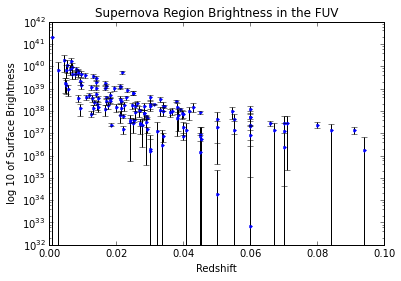

In [28]:
#We create a plot of the results and write them to a pdf file
   
t = Table(out_unique[1:], names=out_unique[0], dtype=(str, 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', str))

ax = plt.gca()
ax.set_yscale('log')
ax.plot(t['Red shift'], t['Surface Brightness (erg s-1 A-1 Kpc^-2)'],'.')
ax.errorbar(t['Red shift'], t['Surface Brightness (erg s-1 A-1 Kpc^-2)'],
            xerr=None, yerr=t['Surface Brightness error (erg s-1 A-1 Kpc^-2)'],
            color='black', linestyle='')


plt.xlabel('Redshift')
plt.ylabel('log 10 of Surface Brightness')
plt.title(plot_name)

plt.savefig(output_file + uv_type + ' plot.pdf')
plt.show()
plt.close()



In [29]:
t

Sn Name,Red shift,Redshift error,ArcMin^2 per Kpc^2 at Redshift,ArcMin^2 / Kpc^2 error,Photometry,Exposure Time (s),Photometry Error N^(1/2)/s,Flux (erg s-1 cm-2 A-1 px-1),Flux error (erg s-1 cm-2 A-1 px-1),Luminosity (erg s-1 A-1 px-1),Luminosity Error (erg s-1 A-1 px-1),Surface Brightness (erg s-1 A-1 Kpc^-2),Surface Brightness error (erg s-1 A-1 Kpc^-2),log10 of Surface Brightness,Error in log10,File Path
str3328,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str3328
SN2008fr,0.039,0.00100145197111,0.000422543917765,2.15420026819e-05,0.0375597929924,1632.0,0.00479735126486,5.25837101894e-17,6.7162917708e-18,1.75969779985e+38,2.4195793343e+37,1.18967936389e+38,1.74462746164e+37,38.0754299284,0.0636879231974,./fits files/Friedman Supernova/2418435336423079936/MISDR1_16952_0422-fd-int.fits
SN2005eq,0.028977,0.00100111174051,0.000762044240145,5.24453193453e-05,0.0178092801677,1693.05,0.00324330862451,2.49329922347e-17,4.54063207432e-18,4.62650394653e+37,9.00437474444e+36,5.64096109514e+37,1.16449565095e+37,37.7513531045,0.0896538775713,./fits files/Friedman Supernova/2422868567306272768/MISDR1_18848_0459-fd-int.fits
SN2010Y,0.01086,0.00100075121286,0.00538268625209,0.00100670321087,0.132173075612,1694.0,0.00883313363407,1.85042305857e-16,1.23663870877e-17,4.86105668517e+37,9.50996082304e+36,4.18648687838e+38,1.1330779512e+38,38.6218497343,0.117542349007,./fits files/Friedman Supernova/2425296288980402176/MISDR1_00398_0490-fd-int.fits
SN2005ch,0.027,0.00100105646716,0.000876967317159,6.48224555063e-05,0.0329078065211,1704.0,0.00439455272874,4.60709291295e-17,6.15237382023e-18,7.42851975435e+37,1.13311256505e+37,1.04233104631e+38,1.76676581725e+37,38.0180056736,0.073613526908,./fits files/Friedman Supernova/2428216591863775232/MISDR1_33770_0534-fd-int.fits
SN2010jv,0.013469,0.00100078292572,0.0035033149979,0.000524861414513,0.0780246590462,2640.0,0.00543643217911,1.09234522665e-16,7.61100505076e-18,4.40899338204e+37,7.21910076408e+36,2.47137482255e+38,5.48483756411e+37,38.3929386179,0.0963850026508,./fits files/Friedman Supernova/2484793062182617088/NGA_NGC2388-fd-int.fits
SN2008fv,0.009346,0.00100073592829,0.00726310843175,0.00158844977791,1.47848771218,1684.15,0.0296291008506,2.06988279705e-15,4.14807411908e-17,4.02978566196e+38,8.65022854635e+37,4.68300323513e+39,1.43507820546e+39,39.6705244578,0.133086934695,./fits files/Friedman Supernova/2486587465159147520/NGA_NGC3147-fd-int.fits
SN2007sr,0.005417,0.00100070694728,0.0215833625191,0.00853752252135,0.310996539223,2334.4,0.0115422413481,4.35395154912e-16,1.61591378873e-17,2.85248393142e+37,1.05798277125e+37,9.8505911635e+38,5.34147239625e+38,38.9934622946,0.235495712737,./fits files/Friedman Supernova/2488487421453271040/NGA_Antennae-fd-int.fits
SN2006X,0.00524,0.0010007060048,0.0230643401017,0.00947780631679,3.74814276767,1754.1,0.0462254225406,5.24739987473e-15,6.47155915568e-17,3.21707989958e+38,1.22801199049e+38,1.18719719901e+40,6.65857853207e+39,40.0745228633,0.243580756104,./fits files/Friedman Supernova/2489367030554165248/NGA_NGC4321-fd-int.fits
SN2008hy,0.008459,0.00100072803755,0.00886276855361,0.00215294422314,0.123208322138,2765.1,0.00667520474982,1.72491650993e-16,9.34528664974e-18,2.75205678657e+37,6.66846797595e+36,3.90253477533e+38,1.33899357805e+38,38.5913467817,0.149010208936,./fits files/Friedman Supernova/2504003729343119360/LGAL_IC334-fd-int.fits


In [24]:
#Write data to an output file

asc.write(out_unique[1:], output_file + uv_type + '.csv', names=out_unique[0], delimiter=",")
asc.write(log[1:], output_file + uv_type + ' log.csv', names=log[0], delimiter=",")
print('Script finished')


Script finished
